In [2]:
# behave like a normal kernel plz
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot inline
%matplotlib inline

In [3]:
import pandas as pd
gene2pubmed = pd.read_table("data/genbank-data/gene2pubmed", sep = "\t")
list(gene2pubmed) # hmm.. the weird # in column header is going to come to bite me if I don't replace it right away !

gene2pubmed.rename(columns={'#tax_id':'tax_id'}, inplace=True)
list(gene2pubmed)

gene2pubmed.shape

['#tax_id', 'GeneID', 'PubMed_ID']

['tax_id', 'GeneID', 'PubMed_ID']

(10695821, 3)

In [4]:
#import sqlite3
#con = sqlite3.connect("NameNode.sqlite")
#cursor = con.cursor()

#index_db = ("CREATE INDEX tid ON NcbiNameNode(tax_id, name_class, name_txt);")
#cursor.execute(index_db)
#con.close()

In [5]:
merged_nodes = pd.read_table("new_taxdmp/merged.dmp", header=None, sep = "|", names=['old_tax_id','new_tax_id','empty'])
merged_nodes = merged_nodes.drop('empty', axis=1)
merged_nodes.head()
merged_nodes.shape

,old_tax_id,new_tax_id
0,12,74109
1,30,29
2,36,184914
3,37,42
4,46,39


(49365, 2)

In [6]:
# df.set_index('id')['value'].to_dict()
merged = merged_nodes.set_index('old_tax_id')['new_tax_id'].to_dict()
len(merged)

49365

In [7]:
merged[10857]

2003327

In [8]:
# Replace gene2pubmed list of merged txid's
for txid in (gene2pubmed['tax_id']):
    if txid in merged:
        print("old " + str(txid))
        new = merged[txid]
        print("new " + str(new))
        gene2pubmed['tax_id'] =  gene2pubmed['tax_id'].replace([txid], new )

old 10857
new 2003327
old 12506
new 1980467
old 34582
new 1934733
old 35758
new 67581
old 78871
new 1828414
old 117575
new 1986029
old 175128
new 1763895
old 181418
new 1592441
old 390978
new 376820
old 415195
new 3171
old 745177
new 166921
old 984915
new 10989
old 1273087
new 1891718
old 1276187
new 1891722
old 1324794
new 1962300
old 1346162
new 1903492
old 1346828
new 1987479
old 1365206
new 1891756
old 1367205
new 58094
old 1479612
new 1972683
old 1608140
new 1980612


In [9]:
gene2pubmed.loc[gene2pubmed['tax_id'] == 10857]
gene2pubmed.loc[gene2pubmed['tax_id'] == 2003327]

,tax_id,GeneID,PubMed_ID


,tax_id,GeneID,PubMed_ID
5196253,2003327,1261203,2607341
5196254,2003327,1261204,2607341
5196255,2003327,1261205,2607341
5196256,2003327,1261206,2607341
5196257,2003327,1261207,2607341
5196258,2003327,1261208,2607341
5196259,2003327,1261209,2607341
5196260,2003327,1261210,2607341
5196261,2003327,1261211,2607341
5196262,2003327,1261212,2607341


In [10]:
gene2pubmed.head()

,tax_id,GeneID,PubMed_ID
0,9,1246500,9873079
1,9,1246501,9873079
2,9,1246502,9812361
3,9,1246502,9873079
4,9,1246503,9873079


In [11]:
txidOnly = gene2pubmed.tax_id.unique()
type(txidOnly)
txidOnly[0:5] # have a peek
len(txidOnly) # number of tax_id's

numpy.ndarray

array([  9,  33, 139, 140, 158])

13950

In [12]:
import sqlite3
con = sqlite3.connect("NameNode.sqlite")   
undetected = []
Dummymaster = pd.DataFrame(columns=("species","genus","family","order","class","phylum","superkingdom","norank"))
count = 0
#txidtest = txidOnly[0:10]
#for tid in txidtest:
for tid in txidOnly:
    ntid = int(tid)
    
    #print(tid)
    df = pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == ? AND name_class == 'scientific name'", con=con, params = (ntid,))
    if df.size == 0:
        undetected.append(tid)
        count += 1
        continue
    
    classi = {'taxid': tid,'species': 'unclassified','genus': 'unclassified','family': 'unclassified','order': 'unclassified','class': 'unclassified','phylum': 'unclassified','superkingdom': 'unclassified','norank': 'unclassified'}
    level = df['rank'][0]
    parent = df['parent_tax_id'][0]
    sciname = df['name_txt'][0]
    taxid = int(df['tax_id'][0])

    while parent != 1:
        #print(taxid)
        con = sqlite3.connect("NameNode.sqlite")
        df = pd.read_sql_query("SELECT tax_id, name_txt,parent_tax_id, rank FROM NcbiNameNode WHERE tax_id == ? AND name_class == 'scientific name'", con = con, params=(taxid,))
        #con.close()
        #df
        
        level = df['rank'][0]
        parent = df['parent_tax_id'][0]
        sciname = df['name_txt'][0]
        #tax_id = df['tax_id'][0]
        taxid = int(df['parent_tax_id'][0])
        classi[level] = sciname
        #classi
    # df = pd.DataFrame.from_dict(sales)
    temp = pd.DataFrame.from_dict([classi])
    temp = temp[['taxid','species','genus','family','order','class','phylum','superkingdom','norank']]
    #temp
    #Dummymaster = Dummymaster.append(temp)
    Dummymaster = pd.concat([Dummymaster,temp],axis=0,join='outer')
    #Dummymaster
    

con.close()
Dummymaster = Dummymaster.reset_index()
Dummymaster[['taxid']] = Dummymaster[['taxid']].astype(int)
#list(Dummymaster)
Dummymaster= Dummymaster[['taxid','species','genus','family','order','class','phylum','superkingdom','norank']] 
print("number of unidentified taxid in db = " + str(count) )

Dummymaster.head()
Dummymaster.shape


number of unidentified taxid in db = 0


,taxid,species,genus,family,order,class,phylum,superkingdom,norank
0,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
1,33,Myxococcus fulvus,Myxococcus,Myxococcaceae,Myxococcales,Deltaproteobacteria,Proteobacteria,Bacteria,unclassified
2,139,Borreliella burgdorferi,Borreliella,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
3,140,Borrelia hermsii,Borrelia,Borreliaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified
4,158,Treponema denticola,Treponema,Spirochaetaceae,Spirochaetales,Spirochaetia,Spirochaetes,Bacteria,unclassified


(13950, 9)

In [13]:
# sanity check for known merged taxids
Dummymaster.loc[Dummymaster['taxid'] == 10857]
Dummymaster.loc[Dummymaster['taxid'] == 2003327]

,taxid,species,genus,family,order,class,phylum,superkingdom,norank


,taxid,species,genus,family,order,class,phylum,superkingdom,norank
1211,2003327,Chlamydia virus Chp1,Chlamydiamicrovirus,Microviridae,unclassified,unclassified,unclassified,Viruses,unclassified


In [14]:
undetected

[]

In [15]:
gene2pubmed.head()

,tax_id,GeneID,PubMed_ID
0,9,1246500,9873079
1,9,1246501,9873079
2,9,1246502,9812361
3,9,1246502,9873079
4,9,1246503,9873079


In [16]:
gene2pubmed_Taxa = pd.merge(gene2pubmed, Dummymaster, left_on='tax_id', right_on='taxid', how='left')
gene2pubmed_Taxa.head()
gene2pubmed_Taxa.shape

,tax_id,GeneID,PubMed_ID,taxid,species,genus,family,order,class,phylum,superkingdom,norank
0,9,1246500,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
1,9,1246501,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
2,9,1246502,9812361,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
3,9,1246502,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
4,9,1246503,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified


(10695821, 12)

In [17]:
# sanity check

import numpy as np

gene2pubmed_Taxa['cmp_txid'] = np.where(gene2pubmed_Taxa['tax_id'] == gene2pubmed_Taxa['taxid'], 'yes','no')
gene2pubmed_Taxa.head()

'no' in gene2pubmed_Taxa.cmp_txid.values

check = gene2pubmed_Taxa.loc[gene2pubmed_Taxa['cmp_txid'] == 'no']
check.head()
check.shape
len(check.tax_id.unique()) # taxa that weren't in the taxonomy database

,tax_id,GeneID,PubMed_ID,taxid,species,genus,family,order,class,phylum,superkingdom,norank,cmp_txid
0,9,1246500,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,yes
1,9,1246501,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,yes
2,9,1246502,9812361,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,yes
3,9,1246502,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,yes
4,9,1246503,9873079,9,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,yes


False

,tax_id,GeneID,PubMed_ID,taxid,species,genus,family,order,class,phylum,superkingdom,norank,cmp_txid


(0, 13)

0

In [18]:
# clean up
gene2pubmed_Taxa = gene2pubmed_Taxa.drop(['taxid', 'cmp_txid'], axis = 1)
gene2pubmed_Taxa.head()

,tax_id,GeneID,PubMed_ID,species,genus,family,order,class,phylum,superkingdom,norank
0,9,1246500,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
1,9,1246501,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
2,9,1246502,9812361,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
3,9,1246502,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified
4,9,1246503,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified


In [19]:
geneinfo = pd.read_table("data/genbank-data/gene_info_cut1-3_9-10", sep = "\t")
list(geneinfo) # darnit # in column header again !

geneinfo.rename(columns={'#tax_id':'tax_id'}, inplace=True)
list(geneinfo)

geneinfo.head()

['#tax_id', 'GeneID', 'Symbol', 'description', 'type_of_gene']

['tax_id', 'GeneID', 'Symbol', 'description', 'type_of_gene']

,tax_id,GeneID,Symbol,description,type_of_gene
0,7,5692769,NEWENTRY,Record to support submission of GeneRIFs for a...,other
1,9,1246500,repA1,putative replication-associated protein,protein-coding
2,9,1246501,repA2,putative replication-associated protein,protein-coding
3,9,1246502,leuA,2-isopropylmalate synthase,protein-coding
4,9,1246503,leuB,3-isopropylmalate dehydrogenase,protein-coding


In [20]:
gene2pubmed_Taxa.shape
geneinfo.shape

(10695821, 11)

(20763367, 5)

In [21]:
G2p_geneinfo = pd.merge(gene2pubmed_Taxa,geneinfo[['GeneID','Symbol','description','type_of_gene']], on='GeneID', how='left')
G2p_geneinfo.shape
G2p_geneinfo.head()

(10695821, 14)

,tax_id,GeneID,PubMed_ID,species,genus,family,order,class,phylum,superkingdom,norank,Symbol,description,type_of_gene
0,9,1246500,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,repA1,putative replication-associated protein,protein-coding
1,9,1246501,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,repA2,putative replication-associated protein,protein-coding
2,9,1246502,9812361,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,leuA,2-isopropylmalate synthase,protein-coding
3,9,1246502,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,leuA,2-isopropylmalate synthase,protein-coding
4,9,1246503,9873079,Buchnera aphidicola,Buchnera,Erwiniaceae,Enterobacterales,Gammaproteobacteria,Proteobacteria,Bacteria,unclassified,leuB,3-isopropylmalate dehydrogenase,protein-coding


In [22]:
import numpy as np
# sanity check

#check = G2p_geneinfo.loc[G2p_geneinfo['description'] == 'NaN']
check = G2p_geneinfo.loc[G2p_geneinfo['description'] == 'NaN']

check


,tax_id,GeneID,PubMed_ID,species,genus,family,order,class,phylum,superkingdom,norank,Symbol,description,type_of_gene


## Most studied genes

In [23]:
gene_gp_pubmedCount = G2p_geneinfo.groupby('GeneID', as_index=False)['PubMed_ID'].agg({'PubMed_pubs': "count",'PubMed_uniqpubs': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
#gene_gp_pubmedCount.sort_values('PubMed_pubs', ascending=False).head(n=10)
#gene_gp_pubmedCount.sort_values('PubMed_uniqpubs', ascending=False).head(n=10)


#gene_gp_pubmedCount.sort_values('PubMed_pubs', ascending=False).tail(n=10)
#gene_gp_pubmedCount.sort_values('PubMed_uniqpubs', ascending=False).tail(n=10)

In [25]:
gene_gp_pubmedCount_desc = pd.merge(gene_gp_pubmedCount,G2p_geneinfo[['GeneID','Symbol','description','type_of_gene']], on='GeneID', how='left')
gene_gp_pubmedCount_desc = gene_gp_pubmedCount_desc.drop_duplicates()
gene_gp_pubmedCount_desc.sort_values('PubMed_uniqpubs', ascending=False).head(n=10)
gene_gp_pubmedCount_desc.sort_values('PubMed_uniqpubs', ascending=False).tail(n=10)

,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description,type_of_gene
749478,7157,8759,8759,TP53,tumor protein p53,protein-coding
1157555,14910,7332,7332,Gt(ROSA)26Sor,"gene trap ROSA 26, Philippe Soriano",ncRNA
740362,7124,5414,5414,TNF,tumor necrosis factor,protein-coding
218039,1956,4870,4870,EGFR,epidermal growth factor receptor,protein-coding
782460,7422,4166,4166,VEGFA,vascular endothelial growth factor A,protein-coding
1499496,22059,4095,4095,Trp53,transformation related protein 53,protein-coding
40862,348,4074,4074,APOE,apolipoprotein E,protein-coding
386234,3569,4052,4052,IL6,interleukin 6,protein-coding
723897,7040,3817,3817,TGFB1,transforming growth factor beta 1,protein-coding
1768450,31271,3613,3613,w,white,protein-coding


,GeneID,PubMed_pubs,PubMed_uniqpubs,Symbol,description,type_of_gene
6733675,16180961,1,1,L593_RS04450,metallophosphoesterase,protein-coding
6733667,16180953,1,1,L593_RS04435,competence protein CinA,protein-coding
6733674,16180960,1,1,L593_RS00155,signal transduction histidine kinase,protein-coding
6733673,16180959,1,1,L593_RS04440,ribokinase,protein-coding
6733672,16180958,1,1,L593_RS13945,serine/threonine protein kinase,protein-coding
6733671,16180957,1,1,L593_RS09945,hypothetical protein,protein-coding
6733670,16180956,1,1,L593_RS01960,hypothetical protein,protein-coding
6733669,16180955,1,1,L593_RS13940,30S ribosomal protein S27ae,protein-coding
6733668,16180954,1,1,L593_RS14650,ABC transporter substrate-binding protein,protein-coding
10695820,112136083,1,1,LOC112136083,Sharpr-MPRA regulatory region 14106,biological-region


The most studied gene is `TP53 tumor protein p53 [ Homo sapiens (human) ]`,the second one is `Gt(ROSA)26Sor gene trap ROSA 26, Philippe Soriano [ Mus musculus (house mouse) ] `. Unsurprisingly 4 of the top 5 genes are from humans.

## Most number of genes studied by species

In [26]:
tx_gp_geneidCount = G2p_geneinfo.groupby('tax_id',as_index=False)['GeneID'].agg({'Genes_count': "count", 'Genes_uniqcount': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
tx_gp_geneidCount.sort_values('Genes_count', ascending=False).head(n=10)
tx_gp_geneidCount.sort_values('Genes_uniqcount', ascending=False).head(n=10)
#tx_gp_geneidCount.sort_values('Genes_pubs', ascending=False).tail(n=10)

,tax_id,Genes_count,Genes_uniqcount
954,9606,1268615,36273
1067,10090,1058077,48448
641,7227,517944,16052
1075,10116,265278,22253
8426,559292,211406,6426
729,7955,137791,22201
8205,511145,107104,4490
321,3702,105137,32303
339,3880,100989,50504
8150,500485,87962,13647


,tax_id,Genes_count,Genes_uniqcount
7591,412133,59513,59467
339,3880,100989,50504
1067,10090,1058077,48448
320,3694,41575,41525
1042,9913,59549,41120
6303,280463,38544,38544
3664,90675,37460,36468
954,9606,1268615,36273
270,3218,36162,35926
3616,88036,34783,34776


In [27]:
tx_gp_geneidCount_tax = pd.merge(tx_gp_geneidCount,G2p_geneinfo[['tax_id','species']], on='tax_id', how='left')
tx_gp_geneidCount_tax = tx_gp_geneidCount_tax.drop_duplicates()

tx_gp_geneidCount_tax.sort_values('Genes_count', ascending=False).head(n=10)
tx_gp_geneidCount_tax.sort_values('Genes_uniqcount', ascending=False).head(n=10)

tx_gp_geneidCount_tax.sort_values('Genes_count', ascending=False).tail(n=10)
tx_gp_geneidCount_tax.sort_values('Genes_uniqcount', ascending=False).tail(n=10)

,tax_id,Genes_count,Genes_uniqcount,species
2367514,9606,1268615,36273,Homo sapiens
3822708,10090,1058077,48448,Mus musculus
1138253,7227,517944,16052,Drosophila melanogaster
4880883,10116,265278,22253,Rattus norvegicus
8493154,559292,211406,6426,Saccharomyces cerevisiae
1966707,7955,137791,22201,Danio rerio
8277699,511145,107104,4490,Escherichia coli
323855,3702,105137,32303,Arabidopsis thaliana
487666,3880,100989,50504,Medicago truncatula
8148968,500485,87962,13647,Penicillium rubens


,tax_id,Genes_count,Genes_uniqcount,species
7794233,412133,59513,59467,Trichomonas vaginalis
487666,3880,100989,50504,Medicago truncatula
3822708,10090,1058077,48448,Mus musculus
282280,3694,41575,41525,Populus trichocarpa
3724859,9913,59549,41120,Bos taurus
7139824,280463,38544,38544,Emiliania huxleyi
5931030,90675,37460,36468,Camelina sativa
2367514,9606,1268615,36273,Homo sapiens
235016,3218,36162,35926,Physcomitrella patens
5882062,88036,34783,34776,Selaginella moellendorffii


,tax_id,Genes_count,Genes_uniqcount,species
10672074,1922960,1,1,Hubei narna-like virus 7
10672073,1922959,1,1,Hubei narna-like virus 5
10672072,1922958,1,1,Hubei narna-like virus 4
10672071,1922957,1,1,Hubei narna-like virus 3
10672070,1922956,1,1,Hubei narna-like virus 25
10672069,1922955,1,1,Hubei narna-like virus 24
10672068,1922954,1,1,Hubei narna-like virus 23
10672067,1922953,1,1,Hubei narna-like virus 22
5637908,52650,1,1,Lagopus lagopus
5673952,62335,1,1,Saccharum spontaneum


,tax_id,Genes_count,Genes_uniqcount,species
10663091,1871153,1,1,Nylanderia fulva virus 1
10663050,1868221,1,1,Porcine circovirus 3
141442,1684,1,1,Bifidobacterium asteroides
5659142,58860,1,1,Tamarindus indica
9056902,666146,1,1,Cleome leaf crumple virus associated DNA 1
9056903,666147,1,1,Euphorbia yellow mosaic alphasatellite
9058423,666635,1,1,Vernonia yellow vein betasatellite
144950,1724,1,1,Corynebacterium renale
144951,1744,1,1,Propionibacterium freudenreichii
5660031,59476,1,1,Pteronotus parnellii


The who's who of model organisms dominate the list of sheer count of genes studied (including duplicates). But if we count only the unique genes studied, some new players show up

In [28]:
#import numpy as np
#totalgenecountbyspp =  tx_gp_geneidCount_tax[['tax_id','Genes_count']].sort_values('Genes_count', ascending=False)
#totalgenecountbyspp.head()
#totalgenecountbyspp['Gene_Count_percent'] = ((gene2pubmed / gene2pubmed.groupby(['tax_id']).transform(sum))['GeneID'])*100
#totalgenecountbyspp['Gene_Count_percent'] = (totalgenecountbyspp['Genes_count']/totalgenecountbyspp['Genes_count'].sum())*100
#totalgenecountbyspp.head(n=10)

# df['sales_ratio'] = (df / df.groupby(['state']).transform(sum))['sales']

# Most studied species

In [35]:
#G2p_geneinfo.head()
tx_gp_pubmedCount_byspp = G2p_geneinfo.groupby('tax_id', as_index=False)['PubMed_ID'].agg({'Pubmed_pubs': "count", 'Pubmed_uniqpubs': "nunique"}) # because pandas preserves the row index and we need it reset to be sorted
#tx_gp_pubmedCount.sort_values('Pubmed_pubs', ascending=False).head(n=10)
tx_gp_pubmedCount_byspp2 = pd.merge(tx_gp_pubmedCount_byspp, G2p_geneinfo[['tax_id','species']], on='tax_id', how='left')
tx_gp_pubmedCount_byspp2 = tx_gp_pubmedCount_byspp2.drop_duplicates()

tx_gp_pubmedCount_byspp2.sort_values('Pubmed_uniqpubs', ascending=False).head(n=10)
tx_gp_pubmedCount_byspp2.sort_values('Pubmed_pubs', ascending=False).head(n=10)

tx_gp_pubmedCount_byspp2.sort_values('Pubmed_uniqpubs', ascending=False).tail(n=10)
tx_gp_pubmedCount_byspp2.sort_values('Pubmed_pubs', ascending=False).tail(n=10)

,tax_id,Pubmed_pubs,Pubmed_uniqpubs,species
2367514,9606,1268615,580429,Homo sapiens
3822708,10090,1058077,289037,Mus musculus
4880883,10116,265278,148262,Rattus norvegicus
1138253,7227,517944,42336,Drosophila melanogaster
8277699,511145,107104,35636,Escherichia coli
8493154,559292,211406,24174,Saccharomyces cerevisiae
323855,3702,105137,18680,Arabidopsis thaliana
1966707,7955,137791,14793,Danio rerio
3724859,9913,59549,9883,Bos taurus
5198625,11676,8385,7663,Human immunodeficiency virus 1


,tax_id,Pubmed_pubs,Pubmed_uniqpubs,species
2367514,9606,1268615,580429,Homo sapiens
3822708,10090,1058077,289037,Mus musculus
1138253,7227,517944,42336,Drosophila melanogaster
4880883,10116,265278,148262,Rattus norvegicus
8493154,559292,211406,24174,Saccharomyces cerevisiae
1966707,7955,137791,14793,Danio rerio
8277699,511145,107104,35636,Escherichia coli
323855,3702,105137,18680,Arabidopsis thaliana
487666,3880,100989,28,Medicago truncatula
8148968,500485,87962,37,Penicillium rubens


,tax_id,Pubmed_pubs,Pubmed_uniqpubs,species
6663888,223104,32,1,Orobanche densiflora
6663920,223129,31,1,Orobanche rapum-genistae
6663951,223139,12,1,Canthigaster jactator
6663963,223148,13,1,Paphia undulata
6663976,223151,13,1,Meretrix lyrata
6663989,223152,12,1,Canthigaster valentini
6664001,223239,13,1,Loxoblemmus equestris
6664014,223252,6,1,Cotton leaf curl Multan virus
6664038,223282,7,1,Macroptilium mosaic Puerto Rico virus
10695738,2067803,83,1,Shibataea chiangshanensis


,tax_id,Pubmed_pubs,Pubmed_uniqpubs,species
10672074,1922960,1,1,Hubei narna-like virus 7
10672073,1922959,1,1,Hubei narna-like virus 5
10672072,1922958,1,1,Hubei narna-like virus 4
10672071,1922957,1,1,Hubei narna-like virus 3
10672070,1922956,1,1,Hubei narna-like virus 25
10672069,1922955,1,1,Hubei narna-like virus 24
10672068,1922954,1,1,Hubei narna-like virus 23
10672067,1922953,1,1,Hubei narna-like virus 22
5637908,52650,1,1,Lagopus lagopus
5673952,62335,1,1,Saccharum spontaneum


In [36]:
import numpy as np
totalpubmedCountspp =  tx_gp_pubmedCount_byspp2[['tax_id','Pubmed_pubs','species']].sort_values('Pubmed_pubs', ascending=False)
totalpubmedCountspp.head()
totalpubmedCountspp['Pubmed_pubs_percent'] = (totalpubmedCountspp['Pubmed_pubs']/totalpubmedCountspp['Pubmed_pubs'].sum())*100
totalpubmedCountspp.head(n=10)

,tax_id,Pubmed_pubs,species
2367514,9606,1268615,Homo sapiens
3822708,10090,1058077,Mus musculus
1138253,7227,517944,Drosophila melanogaster
4880883,10116,265278,Rattus norvegicus
8493154,559292,211406,Saccharomyces cerevisiae


,tax_id,Pubmed_pubs,species,Pubmed_pubs_percent
2367514,9606,1268615,Homo sapiens,11.860847
3822708,10090,1058077,Mus musculus,9.892434
1138253,7227,517944,Drosophila melanogaster,4.842489
4880883,10116,265278,Rattus norvegicus,2.480202
8493154,559292,211406,Saccharomyces cerevisiae,1.976529
1966707,7955,137791,Danio rerio,1.288270
8277699,511145,107104,Escherichia coli,1.001363
323855,3702,105137,Arabidopsis thaliana,0.982973
487666,3880,100989,Medicago truncatula,0.944191
8148968,500485,87962,Penicillium rubens,0.822396


In [37]:
import numpy as np
totalpubmeduniqCountspp =  tx_gp_pubmedCount_byspp2[['tax_id','Pubmed_uniqpubs','species']].sort_values('Pubmed_uniqpubs', ascending=False)
#totalpubmeduniqCountspp.head()
#totalpubmeduniqCountspp.tail()
totalpubmeduniqCountspp['Pubmed_uniqCount_percent'] = (totalpubmeduniqCountspp['Pubmed_uniqpubs']/totalpubmeduniqCountspp['Pubmed_uniqpubs'].sum())*100
totalpubmeduniqCountspp.head(n=10)
totalpubmeduniqCountspp.tail(n=10)

,tax_id,Pubmed_uniqpubs,species,Pubmed_uniqCount_percent
2367514,9606,580429,Homo sapiens,44.761217
3822708,10090,289037,Mus musculus,22.289803
4880883,10116,148262,Rattus norvegicus,11.433591
1138253,7227,42336,Drosophila melanogaster,3.264845
8277699,511145,35636,Escherichia coli,2.748158
8493154,559292,24174,Saccharomyces cerevisiae,1.864238
323855,3702,18680,Arabidopsis thaliana,1.440554
1966707,7955,14793,Danio rerio,1.140799
3724859,9913,9883,Bos taurus,0.762152
5198625,11676,7663,Human immunodeficiency virus 1,0.590951


,tax_id,Pubmed_uniqpubs,species,Pubmed_uniqCount_percent
6663888,223104,1,Orobanche densiflora,0.000077
6663920,223129,1,Orobanche rapum-genistae,0.000077
6663951,223139,1,Canthigaster jactator,0.000077
6663963,223148,1,Paphia undulata,0.000077
6663976,223151,1,Meretrix lyrata,0.000077
6663989,223152,1,Canthigaster valentini,0.000077
6664001,223239,1,Loxoblemmus equestris,0.000077
6664014,223252,1,Cotton leaf curl Multan virus,0.000077
6664038,223282,1,Macroptilium mosaic Puerto Rico virus,0.000077
10695738,2067803,1,Shibataea chiangshanensis,0.000077


Viruses are understudied !

What is the influenced of genome size on gene_id counts ? Can we normalize for the bias? Agreed that E.coli would not have topped the list if genome size was major driving factor. But did viruses not get a fair advantage here because of their rather small genomes?

species,Homo sapiens,Mus musculus,Rattus norvegicus,Drosophila melanogaster,Escherichia coli,Saccharomyces cerevisiae,Arabidopsis thaliana,Danio rerio,Bos taurus,Human immunodeficiency virus 1
Pubmed_uniqCount_percent,44.761217,22.289803,11.433591,3.264845,2.748158,1.864238,1.440554,1.140799,0.762152,0.590951


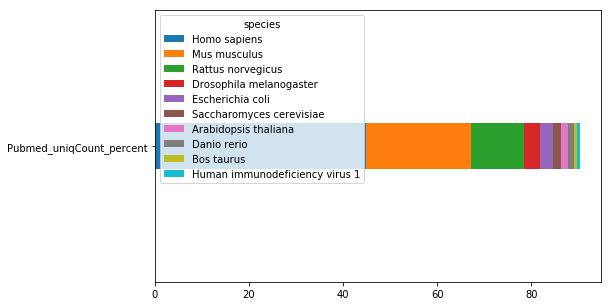

In [38]:
import matplotlib.pyplot as plt
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['species','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head(n=10).set_index('species').T
test
plt.figure(figsize=(20,20))
test.plot.barh(stacked=True, width = 0.1,figsize = (8,5))

species,Homo sapiens,Mus musculus,Rattus norvegicus,Drosophila melanogaster,Escherichia coli,Saccharomyces cerevisiae,Arabidopsis thaliana,Danio rerio,Bos taurus,Human immunodeficiency virus 1
Pubmed_uniqCount_percent,44.761217,22.289803,11.433591,3.264845,2.748158,1.864238,1.440554,1.140799,0.762152,0.590951


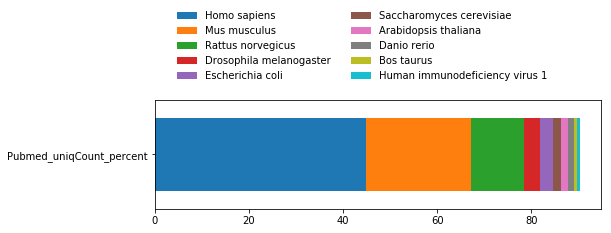

In [40]:
import matplotlib.pyplot as plt
totalpubmeduniqCountspp_per = totalpubmeduniqCountspp[['species','Pubmed_uniqCount_percent']]
test = totalpubmeduniqCountspp_per.head(n=10).set_index('species').T
test
#fig, ax = subplots()
ax = test.plot.barh(stacked=True, width = 1,figsize = (8,2))
#ax.legend(frameon= False, ncol=2)
ax.legend(loc='center right', bbox_to_anchor=(0.9,1.5), ncol=2, frameon=False) # center left

In [ ]:
pmdid_yr = pd.read_table("data/consolidated/recent_pmid_year.ssv", header=None, sep = " ", names=['year','PubMed_ID'])
pmdid_yr.head()